In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import random # библиотека функций для генерации случайных значений
# Сторонние библиотеки
import numpy as np # библиотека функций для работы с матрицами
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical
from keras.models import Sequential
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os

# Нейросеть из Федяниной

In [5]:
""" ---Раздел описаний--- """
""" --Описание класса Network--"""
class Network(object): # используется для описания нейронной сети
    def __init__(self, sizes): # конструктор класса
# self – указатель на объект класса
# sizes – список размеров слоев нейронной сети
        self.num_layers = len(sizes) # задаем количество слоев нейронной сети
        self.sizes = sizes # задаем список размеров слоев нейронной сети
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]] # задаем случайные начальные смещения
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])] # задаем случайные начальные веса связей
    def sigmoid(self,z): # определение сигмоидальной функции активации
        return 1.0/(1.0+np.exp(-z))
    def feedforward(self, a):
        for b, w in zip(self.biases, self.weights):
            a = self.sigmoid(np.dot(w, a)+b)
        return a
    def SGD( # Стохастический градиентный спуск
        self # указатель на объект класса
        , training_data # обучающая выборка
        , epochs # количество эпох обучения
        , mini_batch_size # размер подвыборки
        , eta # скорость обучения
        , test_data # тестирующая выборка
        ):
        test_data = list(test_data) # создаем список объектов тестирующей выборки
        n_test = len(test_data) # вычисляем длину тестирующей выборки
        training_data = list(training_data) # создаем список объектов обучающей выборки
        n = len(training_data) # вычисляем размер обучающей выборки
        for j in range(epochs): # цикл по эпохам
            random.shuffle(training_data) # перемешиваем элементы обучающей выборки
            mini_batches = [training_data[k:k+mini_batch_size] for k in range(0, n, mini_batch_size)] # создаем подвыборки
            for mini_batch in mini_batches: # цикл по подвыборкам
              #print(len(mini_batch[0][0]))
              self.update_mini_batch(mini_batch, eta) # один шаг градиентного спуска
            print ("Epoch {0}: {1} / {2}".format(j, self.evaluate(test_data), n_test)) # смотрим прогресс в обучении
    def update_mini_batch( # Шаг градиентного спуска
        self # указатель на объект класса
        , mini_batch # подвыборка
        , eta # скорость обучения
        ):
        nabla_b = [np.zeros(b.shape) for b in self.biases] # список градиентов dC/db для каждого слоя (первоначально заполняются нулями)
        nabla_w = [np.zeros(w.shape) for w in self.weights] # список градиентов dC/dw для каждого слоя (первоначально заполняются нулями)
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y) # послойно вычисляем градиенты dC/db и dC/dw для текущего прецедента (x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)] # суммируем градиенты dC/db для различных прецедентов текущей подвыборки
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)] # суммируем градиенты dC/dw для различных прецедентов текущей подвыборки
        self.weights = [w-(eta/len(mini_batch))*nw for w, nw in zip(self.weights, nabla_w)] # обновляем все веса w нейронной сети
        self.biases = [b-(eta/len(mini_batch))*nb for b, nb in zip(self.biases, nabla_b)] # обновляем все смещения b нейронной сети
    def backprop( # Алгоритм обратного распространения
        self # указатель на объект класса
      ,x # вектор входных сигналов ,
      ,y # ожидаемый вектор выходных сигналов
      ):
        nabla_b = [np.zeros(b.shape) for b in self.biases] # список градиентов dC/db для каждого слоя (первоначально заполняются нулями)
        nabla_w = [np.zeros(w.shape) for w in self.weights] # список градиентов dC/dw для каждого слоя (первоначально заполняются нулями)
        # определение переменных
        activation = x # выходные сигналы слоя (первоначально соответствует выходным сигналам 1-го слоя или входным сигналам сети)
        activations = [x] # список выходных сигналов по всем слоям (первоначально содержит только выходные сигналы 1-го слоя)
        zs = [] # список активационных потенциалов по всем слоям (первоначально пуст)
        # прямое распространение
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b # считаем активационные потенциалы текущего слоя
            zs.append(z) # добавляем элемент (активационные потенциалы слоя) в конец списка
            activation = self.sigmoid(z) # считаем выходные сигналы текущего слоя, применяя сигмоидальную функцию активации к активационным потенциалам слоя
            activations.append(activation) # добавляем элемент (выходные сигналы слоя) в конец списка
  # обратное распространение
        delta = self.cost_derivative(activations[-1], y) * self.sigmoid_prime(zs[-1]) # считаем меру влияния нейронов выходного слоя L на величину ошибки (BP1)
        nabla_b[-1] = delta # градиент dC/db для слоя L (BP3)
        nabla_w[-1] = np.dot(delta, activations[-2].transpose()) # градиент dC/dw для слоя L (BP4)
        for l in range(2, self.num_layers):
          z = zs[-l] # активационные потенциалы l-го слоя (двигаемся по списку справа налево)
          sp = self.sigmoid_prime(z) # считаем сигмоидальную функцию от активационных потенциалов l-го слоя
          delta = np.dot(self.weights[-l+1].transpose(), delta) * sp # считаем меру влияния нейронов l-го слоя на величину ошибки (BP2)
          nabla_b[-l] = delta # градиент dC/db для l-го слоя (BP3)
          nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())# градиент dC/dw для l-го слоя (BP4)
        return (nabla_b, nabla_w)
    def evaluate(self, test_data): # Оценка прогресса в обучении
        test_results = [(np.argmax(self.feedforward(x)), y) for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)
    def cost_derivative(self, output_activations, y): # Вычисление частных производных стоимостной функции по выходным сигналам последнего слоя
      return (output_activations-y)
    def sigmoid_prime(self,z):# Производная сигмоидальной функции
      return self.sigmoid(z)*(1-self.sigmoid(z))

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import csv
import numpy as np

# Функция для чтения EMNIST-данных из CSV-файла
def read_emnist_csv(file_path):
    data = []
    labels = []
    with open(file_path, 'r') as file:
        csv_reader = csv.reader(file)
        for row in csv_reader:
            # Первый столбец - это метка класса
            label = int(row[0])
            labels.append(label)
            # Остальные столбцы - это пиксели изображения
            image_data = np.array(row[1:], dtype=np.uint8)
            data.append(image_data)
    return np.array(data), np.array(labels)

# Чтение тренировочных данных
train_data, train_labels = read_emnist_csv('/content/drive/MyDrive/train_dataset_2.csv')

# Чтение тестовых данных
test_data, test_labels = read_emnist_csv('/content/drive/MyDrive/test_dataset_2.csv')

# Чтение тренировочных данных
#train_data, train_labels = read_emnist_csv('/content/drive/MyDrive/train_dataset10.csv')

# Чтение тестовых данных
#test_data, test_labels = read_emnist_csv('/content/drive/MyDrive/test_dataset10.csv')

x_train = train_data
y_train = train_labels
x_test = test_data
y_test = test_labels



In [8]:
# Проверьте уникальные значения меток в train_labels и test_labels
unique_train_labels = np.unique(train_labels)
unique_test_labels = np.unique(test_labels)

print("Уникальные метки в train_labels:", unique_train_labels)
print("Уникальные метки в test_labels:", unique_test_labels)

Уникальные метки в train_labels: [0 1 2 3 4 5 6 7 8 9]
Уникальные метки в test_labels: [0 1 2 3 4 5 6 7 8 9]


In [9]:
print("Размеры тренировочных данных:", train_data.shape)
print("Размеры тестовых данных:", test_data.shape)

# И вывести метки для первого образца в тренировочных данных
print("Метка первого образца:", train_labels[0])

Размеры тренировочных данных: (3638, 784)
Размеры тестовых данных: (910, 784)
Метка первого образца: 1


In [10]:
import numpy as np

# Задайте порог для определения, что считать черным цветом
threshold_black = 1

# Задайте порог для определения, что считать белым цветом
threshold_white = 0

# Замените оттенки серого, которые ближе к черному, на черный (0), и оттенки белого, которые ближе к белому, на белый (255)
test_data[test_data < threshold_black] = 0
test_data[(test_data >= threshold_black) & (test_data <= threshold_white)] = 128
test_data[test_data > threshold_white] = 255

train_data[train_data < threshold_black] = 0
train_data[(train_data >= threshold_black) & (train_data <= threshold_white)] = 128
train_data[train_data > threshold_white] = 255

# Замените все пиксели, которые не являются черными, на белые (255)
test_data[test_data != 0] = 255
train_data[train_data != 0] = 255

In [11]:
def vectorized_result(j):
  e = np.zeros((10, 1))
  e[j] = 1.0
  return e

In [12]:
training_inputs = [((np.reshape(x, (784,1)) > 0) * 1.0) for x in (train_data)] # преобразование массивов размера 1 на 784 к массивам размера 784 на 1
training_results = [vectorized_result(y) for y in (train_labels)] # представление цифр от 0 до 9 в виде массивов размера 10 на 1
training_data =list (zip(training_inputs, training_results)) # формируем набор обучающих данных из пар (x, y)

In [13]:
test_inputs = [((np.reshape(x, (784,1)) > 0) * 1.0) for x in (test_data)] # преобразование массивов размера 1 на 784 к массивам размера 784 на 1
#test_results = [vectorized_result(y) for y in (y_test)] # представление цифр от 0 до 9 в виде массивов размера 10 на 1
test_data = list(zip(test_inputs,test_labels)) # формируем набор тестовых данных из пар (x, y)

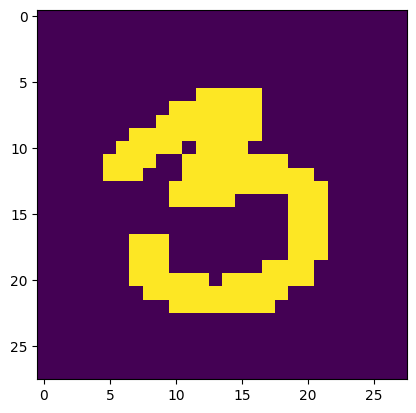

In [14]:
lll8=np.reshape(training_data[512][0],(28,28))
plt.imshow(lll8)
plt.show()

In [15]:
net = Network([784, 30, 10])
""" Вывод результата на экран: """
print('Сеть net:')
print('Количетво слоев:', net.num_layers)
for i in range(net.num_layers):
    print('Количество нейронов в слое', i,':',net.sizes[i])
for i in range(net.num_layers-1):
    print('W_',i+1,':')
    print(np.round(net.weights[i],2))
    print('b_',i+1,':')
    print(np.round(net.biases[i],2))

Сеть net:
Количетво слоев: 3
Количество нейронов в слое 0 : 784
Количество нейронов в слое 1 : 30
Количество нейронов в слое 2 : 10
W_ 1 :
[[ 0.03 -0.47  0.45 ...  1.9   2.08 -0.16]
 [ 0.27  0.05  0.13 ...  2.63  0.06  0.57]
 [ 0.43 -1.16  1.74 ... -1.65  0.1   0.8 ]
 ...
 [-0.59 -0.43  0.9  ...  1.45  0.57  0.37]
 [-0.14  1.15  0.59 ...  1.76 -0.32 -0.62]
 [ 1.92  1.06  1.   ... -0.86  1.32 -1.21]]
b_ 1 :
[[-0.94]
 [-0.8 ]
 [-0.16]
 [-0.16]
 [-0.33]
 [ 0.67]
 [-0.32]
 [ 1.47]
 [-1.18]
 [-0.52]
 [ 1.79]
 [-1.8 ]
 [-1.27]
 [-0.96]
 [-0.76]
 [ 0.78]
 [ 0.29]
 [ 0.33]
 [ 2.18]
 [ 0.89]
 [-0.16]
 [ 1.03]
 [ 2.28]
 [ 0.42]
 [-0.77]
 [-1.55]
 [ 0.29]
 [-0.52]
 [-0.27]
 [ 0.93]]
W_ 2 :
[[-0.97  0.06  1.    1.92  0.59 -0.88 -1.38  0.67 -0.19  0.39  1.45 -0.12
  -0.35  0.85 -0.01 -0.65 -0.02  0.82  1.04  0.06  2.02  0.71 -0.32  0.42
   0.19 -2.56  0.02 -0.18 -1.23 -0.15]
 [ 0.53  1.46 -0.39  0.63 -0.02  1.84  0.69 -0.36 -1.14 -0.58 -0.86  1.23
   0.51 -0.18  0.24 -0.18 -1.23  0.83  1.58 -1.07 -

In [16]:
net.SGD(training_data, 20, 10, 3.0, test_data=test_data)
#         , training_data # обучающая выборка
#         , epochs # количество эпох обучения
#         , mini_batch_size # размер подвыборки
#         , eta # скорость обучения
#         , test_data # тестирующая выборка

Epoch 0: 279 / 910
Epoch 1: 377 / 910
Epoch 2: 439 / 910
Epoch 3: 528 / 910
Epoch 4: 552 / 910
Epoch 5: 567 / 910
Epoch 6: 591 / 910
Epoch 7: 600 / 910
Epoch 8: 584 / 910
Epoch 9: 615 / 910
Epoch 10: 627 / 910
Epoch 11: 624 / 910
Epoch 12: 630 / 910
Epoch 13: 629 / 910
Epoch 14: 626 / 910
Epoch 15: 637 / 910
Epoch 16: 624 / 910
Epoch 17: 635 / 910
Epoch 18: 641 / 910
Epoch 19: 650 / 910


In [17]:
from sklearn.metrics import confusion_matrix

# Forward propagate input to a network output
def forward_propagate(net, row):
    inputs = row
    for i in range(net.num_layers-1):
        new_inputs = []
        for b, w in zip(net.biases[i], net.weights[i]):
            activation = np.dot(w,inputs)+b
            out = net.sigmoid(activation)
            new_inputs.append(out)
        inputs = new_inputs
    return new_inputs



# Make a prediction with a network
def predict(net, row):
    outputs = forward_propagate(net, row)
    return outputs.index(max(outputs))

i=-1
X_train=[]
thresholdedData=[]

for i in range(len(x_train)):
    row=np.reshape(x_train[i], (1,784))
    thresholdedData = (row > 0) * 1.0
    X_train.extend(thresholdedData)


for i in range(len(X_train)):
    prediction = predict(net,X_train[i])
    if (i==0):
      predictTrain = np.array([[prediction]])
    else:
      predictTrain =np.append(predictTrain,[[prediction]],axis=0)

print(confusion_matrix(y_train, predictTrain))

[[318   2   4   0  10   7   4   7   3   5]
 [  1 231  20   3  15  53  19   7   0   4]
 [  2   7 330   2  10  12  10  10   2   6]
 [  0   2   0 314   0   4   5   1   3   0]
 [ 14   2  16   3 318   3   9   8   3  13]
 [  2   9  13   3   3 397  19   5   2   8]
 [  1   7  14   2   2  40 205   1   2   3]
 [  0   2   3   2   4   9   3 348   3   7]
 [  0   4  10   3   4   5  10   4 313   1]
 [  1   0  13   2   8  16   6  14   1 282]]


# Keras свёрточная сеть

In [23]:
train_data_reshaped = x_train.reshape(-1, 28, 28, 1) / 255.0
test_data_reshaped = x_test.reshape(-1, 28, 28, 1) / 255.0

In [24]:
num_classes = 10

In [22]:
# Создайте папку для сохранения моделей, если она не существует
if not os.path.exists('/content/drive/MyDrive/Neuron/saved_modelsCNN'):
    os.makedirs('/content/drive/MyDrive/Neuron/saved_modelsCNN')

# Задайте количество моделей
num_models = 10

for i in range(num_models):
    print(f"Training Model {i + 1}")

    # Создайте модель свёрточной нейронной сети
    model = Sequential()

    # Добавьте слой свертки
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))

    # Добавьте слой пулинга
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Преобразуйте вектор признаков в плоский формат
    model.add(Flatten())

    # Добавьте полносвязные слои
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))  # Количество классов равно num_classes

    # Скомпилируйте модель
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Преобразуйте метки в категориальное представление с учетом количества классов
    train_labels_categorical = to_categorical(train_labels, num_classes=num_classes)
    test_labels_categorical = to_categorical(test_labels, num_classes=num_classes)

    # Добавьте валидационную выборку
    validation_data = (test_data_reshaped, test_labels_categorical)

    # Добавьте раннюю остановку
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Создайте callback для сохранения лучшей модели
    model_checkpoint = ModelCheckpoint(f'/content/drive/MyDrive/Neuron/saved_modelsCNN/best_model_{i + 1}.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

    # Создайте списки для отслеживания ошибки и точности на тренировочной и валидационной выборках
    history = model.fit(train_data_reshaped, train_labels_categorical, epochs=50, batch_size=64,
                        validation_data=validation_data, callbacks=[early_stopping, model_checkpoint])

    # Визуализация графиков и матрицы ошибок (ваш предыдущий код)

    print(f"Training Model {i + 1} Completed")

Training Model 1
Epoch 1/50
56/57 [============================>.] - ETA: 0s - loss: 1.2728 - accuracy: 0.5901
Epoch 1: val_loss improved from inf to 0.84632, saving model to /content/drive/MyDrive/Neuron/saved_modelsCNN/best_model_1.h5
57/57 [==============================] - 7s 77ms/step - loss: 1.2675 - accuracy: 0.5918 - val_loss: 0.8463 - val_accuracy: 0.7484
Epoch 2/50
 1/57 [..............................] - ETA: 3s - loss: 0.6983 - accuracy: 0.7812

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


57/57 [==============================] - ETA: 0s - loss: 0.6078 - accuracy: 0.8114
Epoch 2: val_loss improved from 0.84632 to 0.58241, saving model to /content/drive/MyDrive/Neuron/saved_modelsCNN/best_model_1.h5
57/57 [==============================] - 5s 79ms/step - loss: 0.6078 - accuracy: 0.8114 - val_loss: 0.5824 - val_accuracy: 0.8374
Epoch 3/50
57/57 [==============================] - ETA: 0s - loss: 0.3964 - accuracy: 0.8873
Epoch 3: val_loss improved from 0.58241 to 0.46102, saving model to /content/drive/MyDrive/Neuron/saved_modelsCNN/best_model_1.h5
57/57 [==============================] - 4s 76ms/step - loss: 0.3964 - accuracy: 0.8873 - val_loss: 0.4610 - val_accuracy: 0.8835
Epoch 4/50
56/57 [============================>.] - ETA: 0s - loss: 0.2693 - accuracy: 0.9252
Epoch 4: val_loss improved from 0.46102 to 0.41123, saving model to /content/drive/MyDrive/Neuron/saved_modelsCNN/best_model_1.h5
57/57 [==============================] - 4s 62ms/step - loss: 0.2680 - accuracy

29/29 [==============================] - 0s 6ms/step - loss: 0.3122 - accuracy: 0.9154
Test loss: 0.3121941387653351
Test accuracy: 0.9153845906257629


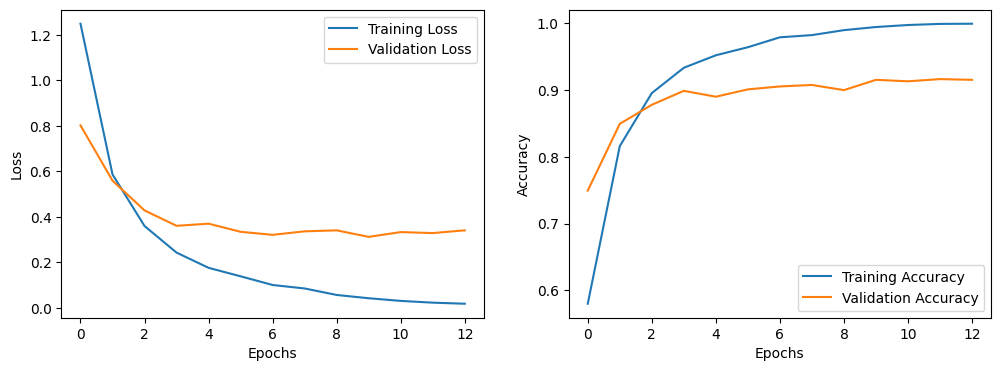

In [25]:
# Оцените производительность модели на тестовых данных
score = model.evaluate(test_data_reshaped, test_labels_categorical)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Постройте графики для оценки переобучения
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

29/29 [==============================] - 0s 6ms/step


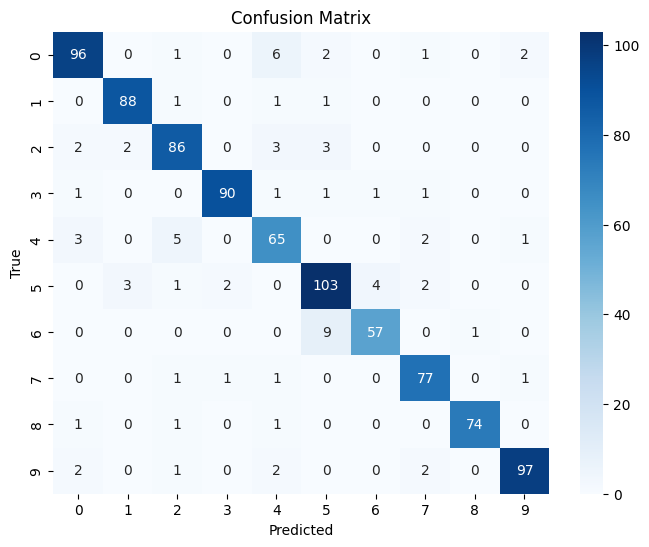

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

predictions = model.predict(test_data_reshaped)
predicted_labels = np.argmax(predictions, axis=1)


conf_matrix = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(test_labels), yticklabels=np.unique(test_labels))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [28]:
from keras.models import load_model
best_model = load_model('/content/drive/MyDrive/Neuron/saved_modelsCNN/best_model_1.h5')  # Путь к файлу с лучшей моделью
score = best_model.evaluate(test_data_reshaped, test_labels_categorical)
print('Best Model Test loss:', score[0])
print('Best Model Test accuracy:', score[1])

29/29 [==============================] - 1s 9ms/step - loss: 0.3186 - accuracy: 0.9132
Best Model Test loss: 0.31857001781463623
Best Model Test accuracy: 0.91318678855896


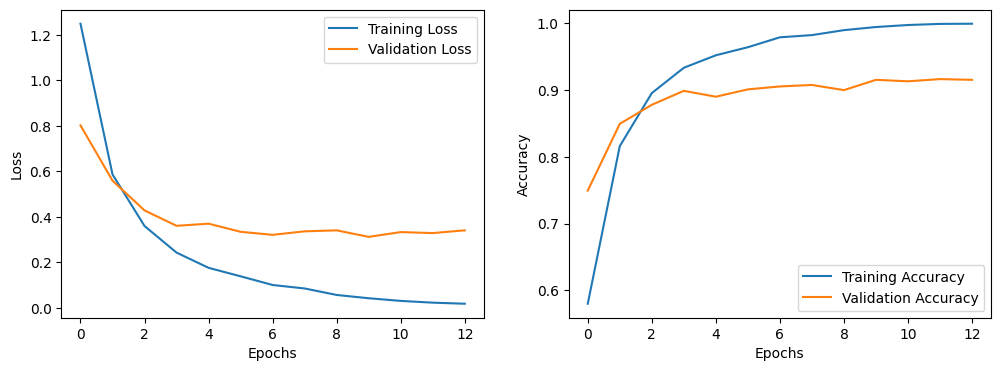

In [29]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

29/29 [==============================] - 0s 9ms/step


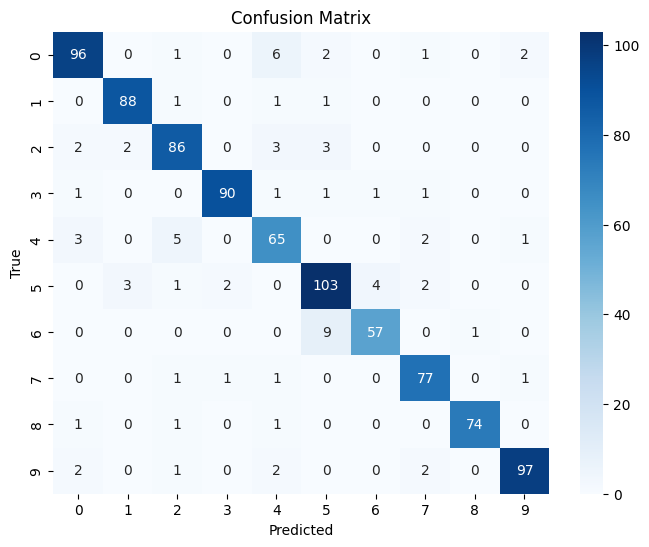

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

predictions = model.predict(test_data_reshaped)
predicted_labels = np.argmax(predictions, axis=1)


conf_matrix = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(test_labels), yticklabels=np.unique(test_labels))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Keras с несколькими слоями

In [31]:
train_images = x_train / 255.0  # Нормализация значений пикселей
test_images = x_test / 255.0


In [32]:
model = keras.Sequential([
    Dense(128, activation='relu'),  # Скрытый слой с 128 нейронами и ReLU активацией
    Dense(64, activation='relu'),   # Скрытый слой с 64 нейронами и ReLU активацией
    Dense(10, activation='softmax')  # Выходной слой с 10 нейронами (10 классов букв) и softmax активацией
])

# Компиляция модели
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Функция потерь для задачи классификации
              metrics=['accuracy'])

# Обучение модели с валидацией
num_epochs = 10  # Количество эпох
history = model.fit(train_images, train_labels, epochs=num_epochs, validation_data=(test_images, test_labels))

# Оценка производительности модели
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Точность на тестовых данных: {test_acc}")

# Построение графиков для оценки переобучения
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

Epoch 1/10
114/114 [==============================] - 1s 6ms/step - loss: 1.3917 - accuracy: 0.5432 - val_loss: 0.9824 - val_accuracy: 0.6868
Epoch 2/10
114/114 [==============================] - 1s 5ms/step - loss: 0.7790 - accuracy: 0.7551 - val_loss: 0.7982 - val_accuracy: 0.7462
Epoch 3/10
114/114 [==============================] - 1s 4ms/step - loss: 0.5740 - accuracy: 0.8202 - val_loss: 0.6959 - val_accuracy: 0.7703
Epoch 4/10
114/114 [==============================] - 1s 5ms/step - loss: 0.4142 - accuracy: 0.8777 - val_loss: 0.6519 - val_accuracy: 0.8033
Epoch 5/10
114/114 [==============================] - 1s 5ms/step - loss: 0.3068 - accuracy: 0.9115 - val_loss: 0.6245 - val_accuracy: 0.8132
Epoch 6/10
114/114 [==============================] - 1s 5ms/step - loss: 0.2257 - accuracy: 0.9393 - val_loss: 0.5817 - val_accuracy: 0.8286
Epoch 7/10
114/114 [==============================] - 1s 5ms/step - loss: 0.1669 - accuracy: 0.9623 - val_loss: 0.5958 - val_accuracy: 0.8264
Epoch 

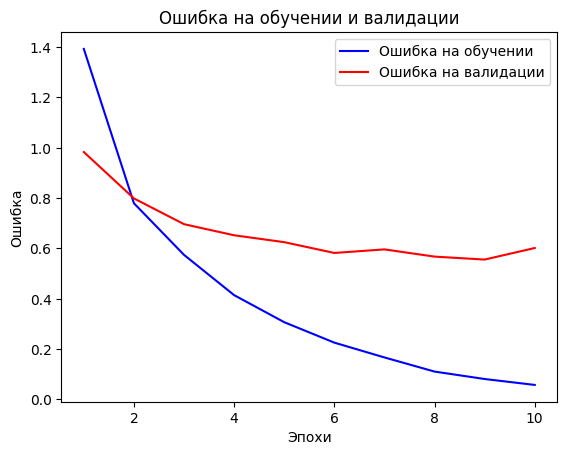

In [33]:
plt.figure()
plt.plot(epochs, train_loss, 'b', label='Ошибка на обучении')
plt.plot(epochs, val_loss, 'r', label='Ошибка на валидации')
plt.title('Ошибка на обучении и валидации')
plt.xlabel('Эпохи')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

In [34]:
import csv
import numpy as np

# Функция для чтения EMNIST-данных из CSV-файла
def read_emnist_csv(file_path):
    data = []
    labels = []
    with open(file_path, 'r') as file:
        csv_reader = csv.reader(file)
        for row in csv_reader:
            # Первый столбец - это метка класса
            label = int(row[0])
            labels.append(label)
            # Остальные столбцы - это пиксели изображения
            image_data = np.array(row[1:], dtype=np.uint8)
            data.append(image_data)
    return np.array(data), np.array(labels)

# Чтение тренировочных данных
train_data, train_labels = read_emnist_csv('/content/drive/MyDrive/train_dataset_2.csv')

# Чтение тестовых данных
test_data, test_labels = read_emnist_csv('/content/drive/MyDrive/test_dataset_2.csv')

# Чтение тренировочных данных
#train_data, train_labels = read_emnist_csv('/content/drive/MyDrive/train_dataset10.csv')

# Чтение тестовых данных
#test_data, test_labels = read_emnist_csv('/content/drive/MyDrive/test_dataset10.csv')

x_train = train_data
y_train = train_labels
x_test = test_data
y_test = test_labels



In [35]:
import numpy as np

# Задайте порог для определения, что считать черным цветом
threshold_black = 1

# Задайте порог для определения, что считать белым цветом
threshold_white = 0

# Замените оттенки серого, которые ближе к черному, на черный (0), и оттенки белого, которые ближе к белому, на белый (255)
test_data[test_data < threshold_black] = 0
test_data[(test_data >= threshold_black) & (test_data <= threshold_white)] = 128
test_data[test_data > threshold_white] = 255

train_data[train_data < threshold_black] = 0
train_data[(train_data >= threshold_black) & (train_data <= threshold_white)] = 128
train_data[train_data > threshold_white] = 255

# Замените все пиксели, которые не являются черными, на белые (255)
test_data[test_data != 0] = 255
train_data[train_data != 0] = 255

In [36]:
# Создание объекта ранней остановки
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Различные конфигурации для моделей
layer_configs = [(128, 64), (256, 128, 64), (64, 32, 16)]

# Путь для сохранения моделей
save_path = '/content/drive/MyDrive/Neuron/saved_models1'

Epoch 1/30
105/114 [==========================>...] - ETA: 0s - loss: 23.3234 - accuracy: 0.3938

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


114/114 [==============================] - 2s 9ms/step - loss: 22.1242 - accuracy: 0.3991 - val_loss: 8.3113 - val_accuracy: 0.5033
Epoch 2/30
114/114 [==============================] - 1s 8ms/step - loss: 4.8028 - accuracy: 0.5704 - val_loss: 4.7828 - val_accuracy: 0.5659
Epoch 3/30
114/114 [==============================] - 1s 9ms/step - loss: 2.3425 - accuracy: 0.6564 - val_loss: 3.6078 - val_accuracy: 0.6011
Epoch 4/30
114/114 [==============================] - 1s 9ms/step - loss: 1.4433 - accuracy: 0.7188 - val_loss: 3.1983 - val_accuracy: 0.6165
Epoch 5/30
114/114 [==============================] - 1s 9ms/step - loss: 1.0594 - accuracy: 0.7573 - val_loss: 3.0571 - val_accuracy: 0.6264
Epoch 6/30
114/114 [==============================] - 1s 6ms/step - loss: 0.6774 - accuracy: 0.8213 - val_loss: 3.0667 - val_accuracy: 0.6330
Epoch 7/30
114/114 [==============================] - 1s 5ms/step - loss: 0.5366 - accuracy: 0.8419 - val_loss: 2.9742 - val_accuracy: 0.6440
Epoch 8/30
114/1

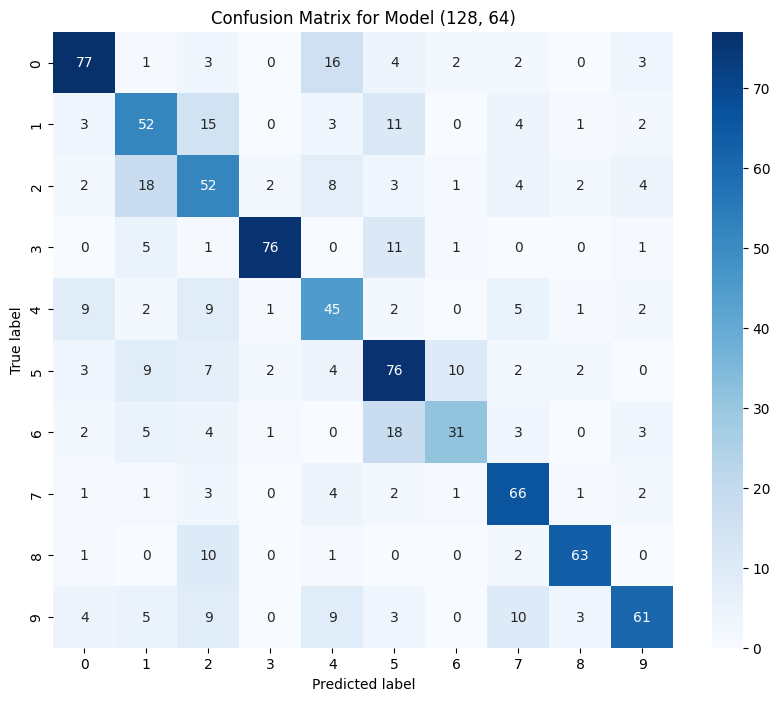

Epoch 1/30
111/114 [============================>.] - ETA: 0s - loss: 12.7858 - accuracy: 0.4226

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


114/114 [==============================] - 2s 9ms/step - loss: 12.5646 - accuracy: 0.4252 - val_loss: 4.1089 - val_accuracy: 0.5330
Epoch 2/30
114/114 [==============================] - 1s 7ms/step - loss: 2.3928 - accuracy: 0.5968 - val_loss: 2.3992 - val_accuracy: 0.5780
Epoch 3/30
114/114 [==============================] - 1s 8ms/step - loss: 1.0656 - accuracy: 0.7312 - val_loss: 1.9575 - val_accuracy: 0.6308
Epoch 4/30
114/114 [==============================] - 1s 10ms/step - loss: 0.6196 - accuracy: 0.8158 - val_loss: 1.8368 - val_accuracy: 0.6736
Epoch 5/30
114/114 [==============================] - 1s 11ms/step - loss: 0.4041 - accuracy: 0.8749 - val_loss: 1.8509 - val_accuracy: 0.6747
Epoch 6/30
114/114 [==============================] - 1s 11ms/step - loss: 0.2399 - accuracy: 0.9159 - val_loss: 1.9281 - val_accuracy: 0.6923
Epoch 7/30
29/29 [==============================] - 0s 4ms/step - loss: 1.8368 - accuracy: 0.6736
Точность на тестовых данных для модели (256, 128, 64): 0.

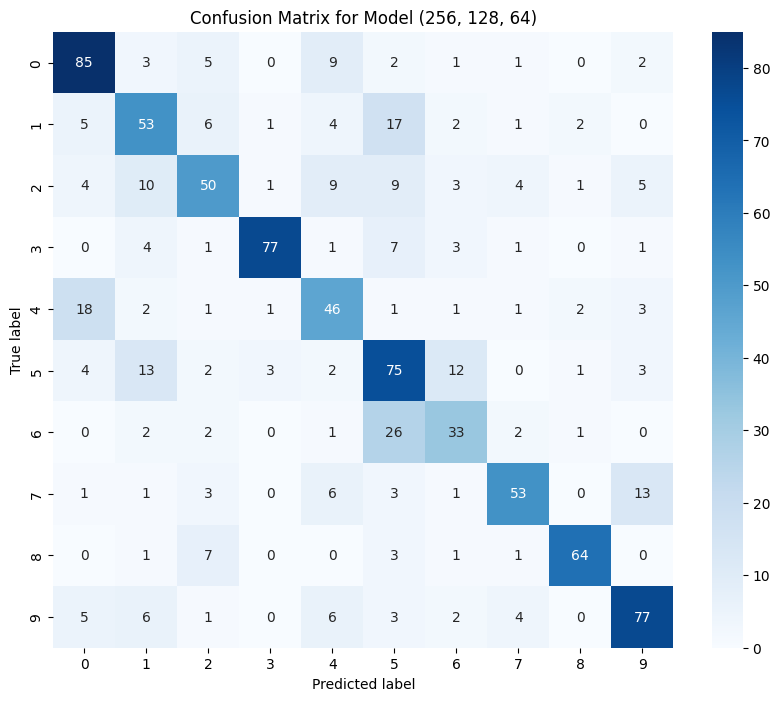

Epoch 1/30
114/114 [==============================] - ETA: 0s - loss: 11.5692 - accuracy: 0.1809

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


114/114 [==============================] - 2s 9ms/step - loss: 11.5692 - accuracy: 0.1809 - val_loss: 3.2378 - val_accuracy: 0.1659
Epoch 2/30
114/114 [==============================] - 0s 4ms/step - loss: 2.3834 - accuracy: 0.2114 - val_loss: 2.2065 - val_accuracy: 0.2176
Epoch 3/30
114/114 [==============================] - 0s 4ms/step - loss: 2.0529 - accuracy: 0.2570 - val_loss: 2.1668 - val_accuracy: 0.2703
Epoch 4/30
114/114 [==============================] - 0s 4ms/step - loss: 1.9191 - accuracy: 0.3002 - val_loss: 2.1058 - val_accuracy: 0.2923
Epoch 5/30
114/114 [==============================] - 0s 4ms/step - loss: 1.8124 - accuracy: 0.3447 - val_loss: 1.9956 - val_accuracy: 0.3286
Epoch 6/30
114/114 [==============================] - 0s 4ms/step - loss: 1.7279 - accuracy: 0.3683 - val_loss: 2.0847 - val_accuracy: 0.3209
Epoch 7/30
114/114 [==============================] - 0s 4ms/step - loss: 1.6572 - accuracy: 0.3994 - val_loss: 1.9337 - val_accuracy: 0.3571
Epoch 8/30
114/1

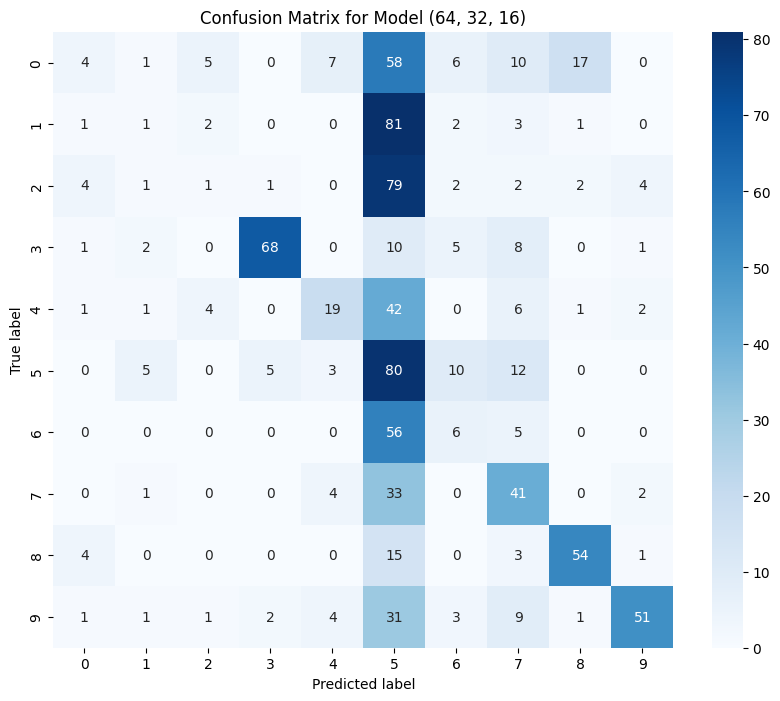

In [37]:

# Создание объекта ранней остановки
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

for layers in layer_configs:
    # Создание модели
    model = keras.Sequential([Dense(units, activation='relu') for units in layers] +
                             [Dense(10, activation='softmax')])

    # Компиляция модели
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Создание объекта ModelCheckpoint для сохранения лучшей модели
    checkpoint_path = os.path.join(save_path, f'model_{str(layers)}', 'best_model.h5')
    model_checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss', mode='min')

    # Обучение модели с ранней остановкой и сохранением лучшей модели
    num_epochs = 30  # количество эпох
    history = model.fit(train_data, train_labels, epochs=num_epochs,
                        validation_data=(test_data, test_labels),
                        callbacks=[early_stopping, model_checkpoint])

    # Загрузка лучшей модели
    best_model = keras.models.load_model(checkpoint_path)

    # Оценка производительности лучшей модели
    test_loss, test_acc = best_model.evaluate(test_data, test_labels)
    print(f"Точность на тестовых данных для модели {layers}: {test_acc}")

    # Построение confusion matrix
    predictions = best_model.predict(test_data)
    conf_matrix = confusion_matrix(test_labels, np.argmax(predictions, axis=1))

    # Визуализация confusion matrix с использованием seaborn
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.title(f'Confusion Matrix for Model {str(layers)}')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()